In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(), '..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)

In [20]:
import g_selfatt.groups as groups
import torch
import models
from g_selfatt.utils import num_params
import torch
import torchvision
from datasets import MNIST_rot
import matplotlib.pyplot as plt
import numpy as np
import models
import torch
import g_selfatt.groups as groups
import models
from torch.cuda.amp import GradScaler, autocast

In [30]:
model = models.GroupTransformer(
    group=groups.E2(num_elements=8),
    in_channels=1,
    num_channels=20,
    block_sizes=[2, 3],
    expansion_per_block=1,
    crop_per_layer=[2, 0, 2, 1, 1],
    image_size=28,
    num_classes=2,
    dropout_rate_after_maxpooling=0.0,
    maxpool_after_last_block=False,
    normalize_between_layers=False,
    patch_size=5,
    num_heads=9,
    norm_type="LayerNorm",
    activation_function="Swish",
    attention_dropout_rate=0.1,
    value_dropout_rate=0.1,
    whitening_scale=1.41421356,
)
model_path = "../saved/results/rotMNIST_model_p4msa_type_Local_patch_5_dpatt_0.1_dpval_0.1_activ_Swish_norm_LayerNorm_white_1.41421356_optim_Adam_lr_0.001_bs_16_ep_50_wd_0.0001_seed_0_sched_constants_schdec_1.0.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>

In [31]:
data_mean = (0.1307,)
data_stddev = (0.3081,)
transform_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(data_mean, data_stddev),
    ]
)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

In [32]:
data = iter(test_loader)

Target: 8


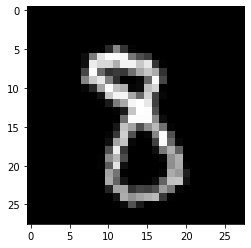

8 with probability 1.0
Target: 8


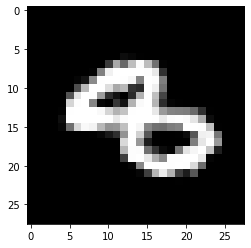

8 with probability 1.0
Target: 3


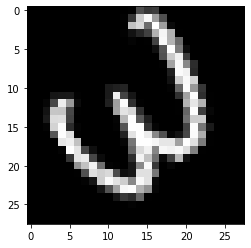

3 with probability 1.0
Target: 3


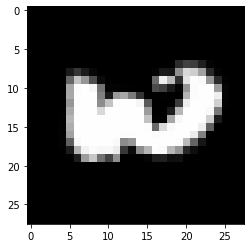

8 with probability 0.7339851260185242
Target: 8


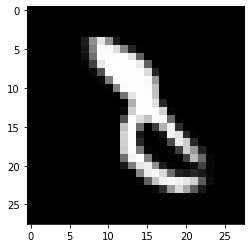

8 with probability 0.999996542930603


In [37]:
idx_2_target = {
    0: 3,
    1: 8
}

model.eval()
with torch.no_grad():
    for _ in range(5):
        example_image, example_idx = next(data)
        out = model(example_image)
        example_image = example_image.squeeze()  # Batch dimension
        print(f"Target: {idx_2_target[example_idx.item()]}")
        plt.imshow(example_image.cpu().numpy(), cmap="gray")
        plt.show()
        _, preds = torch.max(out, 1)
        print(f"{idx_2_target[preds.item()]} with probability {torch.softmax(out, dim=1)[0][preds].item()}")

In [52]:
# for name, param in model.named_parameters():
#     print(name)

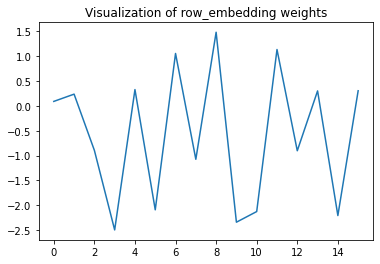

In [49]:
module = model.module
weights = module.lifting_self_attention.row_embedding[0].weight.detach().cpu().numpy()

plt.plot(weights.squeeze())
plt.title('Visualization of row_embedding weights')
plt.show()

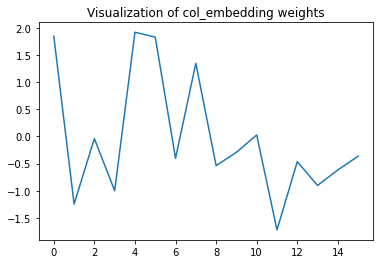

In [50]:
weights = module.lifting_self_attention.col_embedding[0].weight.detach().cpu().numpy()
plt.plot(weights.squeeze())
plt.title('Visualization of col_embedding weights')
plt.show()

In [51]:
# Iterate over named modules
# for name, module in model.named_modules():
#     print(name)

In [ ]:
# todo visualize attention and all the different layers
# just a bunch of explainability